In [2]:
import numpy
import scipy.sparse
from matplotlib import pyplot
import os
import pickle

pyplot.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

## Skip to "ZZ" cells if you're just loading data

In [3]:
import qubit_matmul
import shadow_reconstruction

In [4]:
splus = numpy.array([
    [0.0, 0.0],
    [1.0, 0.0]
])
sminus = numpy.array([
    [0.0, 1.0],
    [0.0, 0.0]
])
sz = numpy.array([
    [-1.0, 0.0],
    [0.0, 1.0]
])

spm = numpy.kron(splus, sminus)
smp = numpy.kron(sminus, splus)
szz = numpy.kron(sz,sz)
szi = numpy.kron(sz,numpy.eye(2))
siz = numpy.kron(numpy.eye(2),sz)

def make_z(i):
    return qubit_matmul.TensorMatf64([i], sz.flatten())

def make_zz(i,j):
    return qubit_matmul.TensorMatf64([i,j], szz.flatten())

def make_pm(i,j):
    return qubit_matmul.TensorMatf64([i, j], spm.flatten())

def make_pmpm(i,j,k,l):
    return qubit_matmul.TensorMatf64([i, j,k,l], numpy.kron(spm,spm).flatten())

In [5]:
base_dirs = {
    "/Users/sumner/Desktop/NumConsShadows/xxz_l16_jm2_open/": (16, -2.0),
    "/Users/sumner/Desktop/NumConsShadows/xxz_l16_jm1_open/": (16, -1.0),
    "/Users/sumner/Desktop/NumConsShadows/xxz_l16_jm05_open/": (16, -0.5),
    "/Users/sumner/Desktop/NumConsShadows/xxz_l16_j0_open/": (16, 0.0),
}

data = {}

for k, (l, j) in base_dirs.items():
    gs = None
    all_samples = []
    for bb, _, ff in os.walk(k):
        for f in ff:
            filename = os.path.join(bb,f)
            if f.endswith('.data'):
                samples = shadow_reconstruction.Samples.load_from(filename)
                all_samples.append(samples)
            elif gs is None and f.endswith(".npz"):
                gs = numpy.load(filename)['gs']
    acc = all_samples[0]
    for s in all_samples[1:]:
        acc.add_from(s)
    data[k] = (l,j,acc,gs)

# ZZ

In [6]:
if not os.path.exists('zzplot_data.pickle'):
    zzplot_data = []
    for (l, j, super_samples, gs) in data.values():
        samples = super_samples # Subset if desired
        raw_data = []
        recon_data = []
        recon_data_std = []
        truth_data = []

        recon = shadow_reconstruction.Reconstruction()
        for r in range(1,l):
            corr_check = make_zz(0,r).get_sparse(l)
            ground_truth = gs @ (corr_check @ gs)
            truth_data.append(ground_truth)

            string = ['I'] * l
            string[0] = 'Z'
            string[r] = 'Z'
            string = ''.join(string)
            estimates = recon.estimate_string_for_each_sample(string, samples)
            raw_data.append(estimates)
            recon_data.append(estimates.mean())
            recon_data_std.append(estimates.std()/numpy.sqrt(len(estimates)))
        recon_data = numpy.array(recon_data)
        recon_data_std = numpy.array(recon_data_std)
        truth_data = numpy.array(truth_data)
        zzplot_data.append((l,j,truth_data, recon_data, recon_data_std, raw_data))
    
    with open('zzplot_data.pickle', 'wb') as w:
        pickle.dump(zzplot_data, w)
else:
    with open('zzplot_data.pickle', 'rb') as f:
        zzplot_data = pickle.load(f)

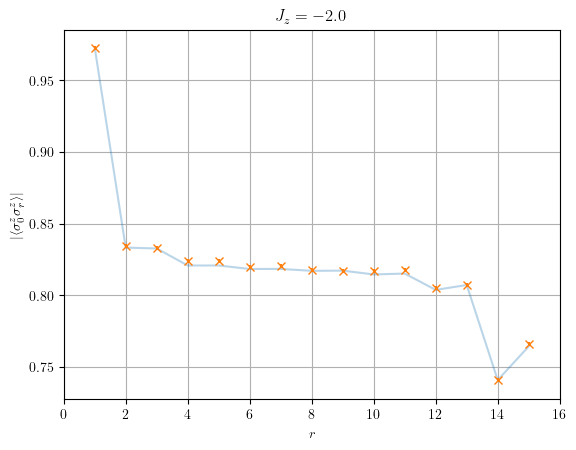

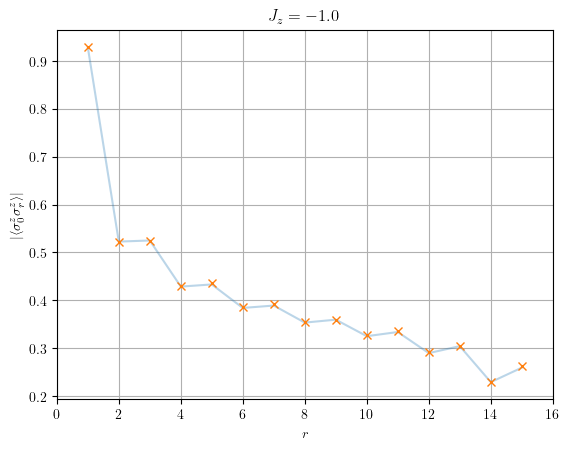

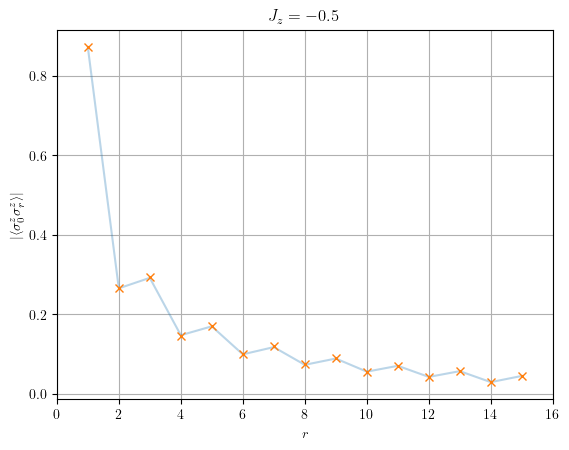

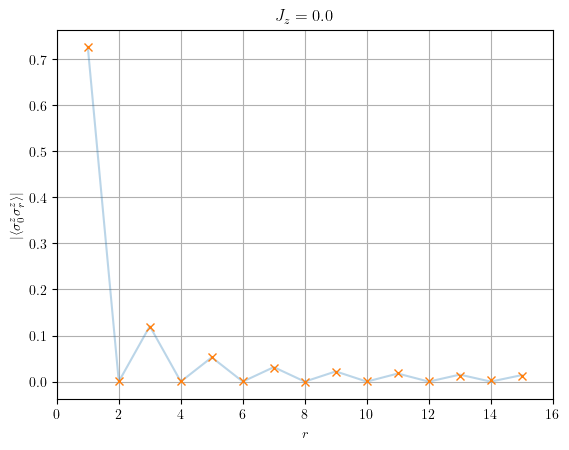

In [7]:
for (l,j,truth_data, recon_data, recon_data_std, _) in zzplot_data:
    pyplot.plot(range(1,l), abs(truth_data), alpha=0.3)
    pyplot.errorbar(range(1,l), abs(recon_data), yerr=recon_data_std, fmt='x')
    pyplot.title(r'$J_z={:.1f}$'.format(j))
    pyplot.ylabel(r'$|\langle \sigma^{z}_0 \sigma^{z}_r \rangle|$')
    pyplot.xlabel('$r$')
    pyplot.grid()
    pyplot.xlim([0,16])
    pyplot.savefig('zzj{:.3f}.jpeg'.format(j))
    pyplot.show()

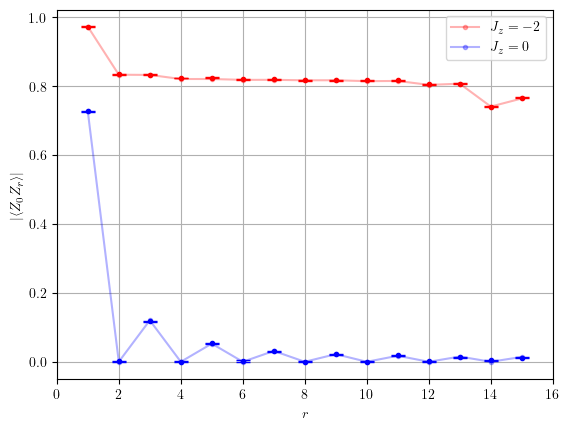

In [9]:
for (l,j,truth_data, recon_data, recon_data_std, _) in zzplot_data:
    near_zero = abs(j - 0.0) < 1e-6
    near_two = abs(j - (-2.0)) < 1e-6
    if near_zero or near_two:
        if near_zero:
            c = 'blue'
        else:
            c = 'red'
        pyplot.plot(range(1,l), abs(truth_data), '.-', alpha=0.3, c=c, label=r'$J_z={:.0f}$'.format(j))
        pyplot.errorbar(range(1,l), abs(recon_data), yerr=recon_data_std, c=c, fmt='.', capsize=5)
pyplot.ylabel(r'$|\langle Z_0 Z_r \rangle|$')
pyplot.xlabel('$r$')
pyplot.grid()
pyplot.xlim([0,16])
pyplot.legend(loc='upper right')
pyplot.savefig('zzj_comp.pdf'.format(j))
pyplot.show()

# PM

In [10]:
if not os.path.exists('pmplot_data.pickle'):
    plot_data = []
    for (l, j, super_samples, gs) in data.values():
        samples = super_samples # Subset if desired
        raw_data = []
        recon_data = []
        recon_data_std = []
        truth_data = []

        recon = shadow_reconstruction.Reconstruction()
        for r in range(1,l):
            corr_check = make_pm(0,r).get_sparse(l)
            ground_truth = gs @ (corr_check @ gs)
            truth_data.append(ground_truth)

            string = ['I'] * l
            string[0] = '+'
            string[r] = '-'
            string = ''.join(string)
            estimates = recon.estimate_string_for_each_sample(string, samples)
            raw_data.append(estimates)
            recon_data.append(estimates.mean())
            recon_data_std.append(estimates.std()/numpy.sqrt(len(estimates)))
        recon_data = numpy.array(recon_data)
        recon_data_std = numpy.array(recon_data_std)
        truth_data = numpy.array(truth_data)
        plot_data.append((l,j,truth_data, recon_data, recon_data_std, raw_data))
    with open('pmplot_data.pickle', 'wb') as w:
        pickle.dump(plot_data, w)
else:
    with open('pmplot_data.pickle', 'rb') as f:
        plot_data = pickle.load(f)

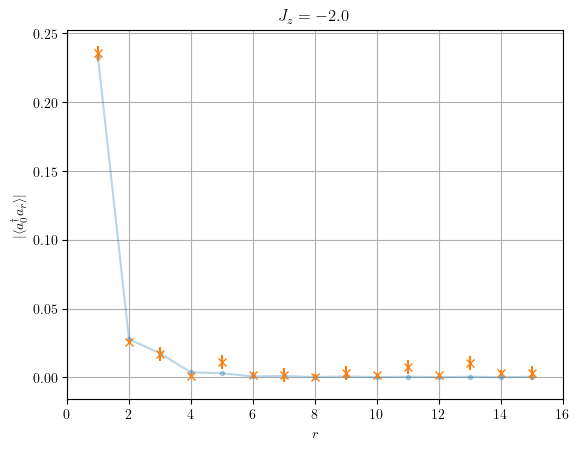

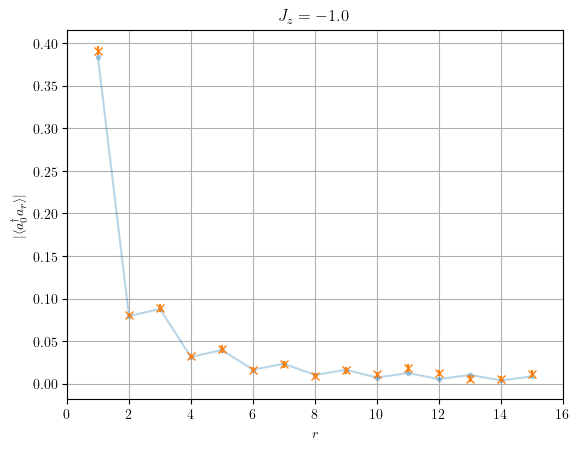

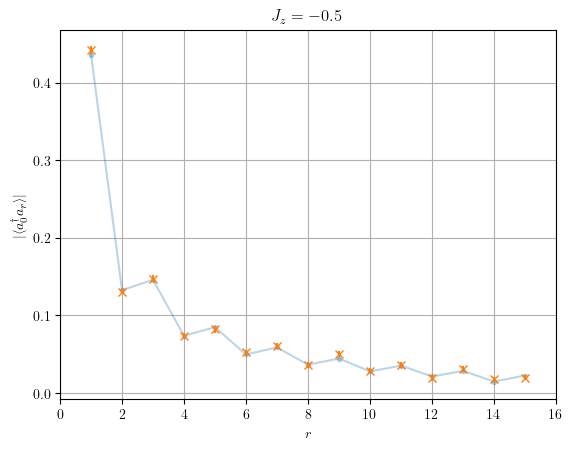

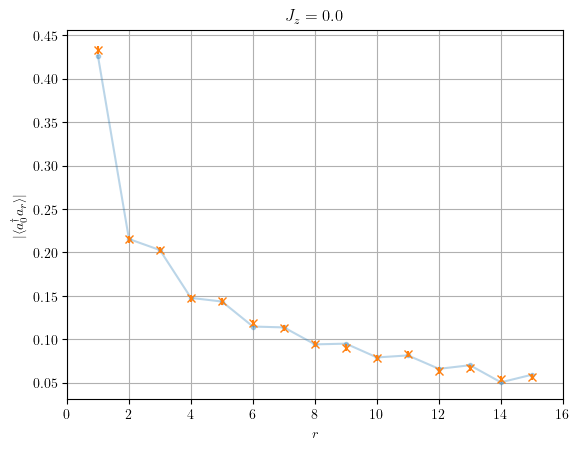

In [11]:
for (l,j,truth_data, recon_data, recon_data_std, _) in plot_data:
    pyplot.plot(range(1,l), abs(truth_data), '.-', alpha=0.3)
    pyplot.errorbar(range(1,l), abs(recon_data), yerr=recon_data_std, fmt='x')
    pyplot.title(r'$J_z={:.1f}$'.format(j))
    pyplot.ylabel(r'$|\langle a^{\dagger}_0 a_r \rangle|$')
    pyplot.xlabel('$r$')
    pyplot.xlim([0,16])
    pyplot.grid()
    pyplot.savefig('pmj{:.3f}.pdf'.format(j))
    pyplot.show()

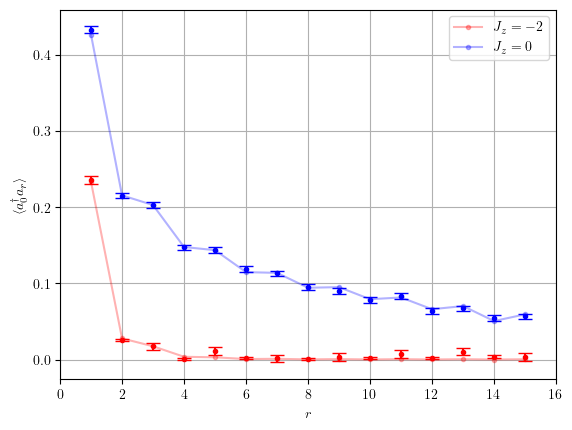

In [14]:
for (l,j,truth_data, recon_data, recon_data_std, _) in plot_data:
    near_zero = abs(j - 0.0) < 1e-6
    near_two = abs(j - (-2.0)) < 1e-6
    if near_zero or near_two:
        if near_zero:
            c = 'blue'
        else:
            c = 'red'
        pyplot.plot(range(1,l), abs(truth_data).real, '.-', alpha=0.3, c=c, label=r'$J_z={:.0f}$'.format(j))
        pyplot.errorbar(range(1,l), abs(recon_data).real, yerr=recon_data_std, c=c, fmt='.', capsize=5)
pyplot.ylabel(r'$\langle a^{\dagger}_0 a_r \rangle$')
pyplot.xlabel('$r$')
pyplot.grid()
pyplot.xlim([0,16])
pyplot.legend(loc='upper right')
pyplot.savefig('pmj_comp.pdf'.format(j))
pyplot.show()

# PMPM

In [15]:
if not os.path.exists('pmpmplot_data.pickle'):
    pmpmplot_data = []
    for (l, j, super_samples, gs) in data.values():
        samples = super_samples # Subset if desired
        recon_data = []
        recon_data_std = []
        truth_data = []
        raw_data = []

        recon = shadow_reconstruction.Reconstruction()
        for r in range(1+1,l-1):
            corr_check = make_pmpm(0,1,r,r+1).get_sparse(l)
            ground_truth = gs @ (corr_check @ gs)
            truth_data.append(ground_truth)

            string = ['I'] * l
            string[0] = '+'
            string[1] = '-'
            string[r] = '+'
            string[r+1] = '-'
            string = ''.join(string)
            estimates = recon.estimate_string_for_each_sample(string, samples)
            raw_data.append(estimates)
            recon_data.append(estimates.mean())
            recon_data_std.append(estimates.std()/numpy.sqrt(len(estimates)))
        recon_data = numpy.array(recon_data)
        recon_data_std = numpy.array(recon_data_std)
        truth_data = numpy.array(truth_data)
        pmpmplot_data.append((l,j,truth_data, recon_data, recon_data_std, raw_data))
    with open('pmpmplot_data.pickle', 'wb') as w:
        pickle.dump(pmpmplot_data, w)
else:
    with open('pmpmplot_data.pickle', 'rb') as f:
        pmpmplot_data = pickle.load(f)

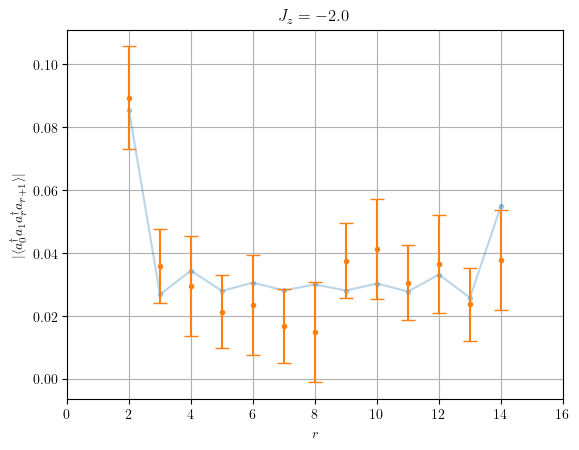

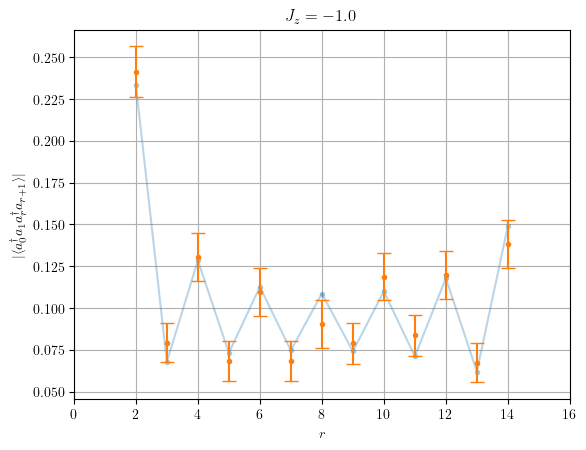

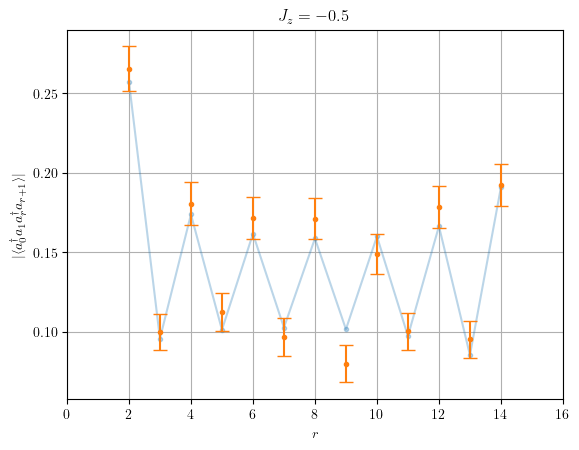

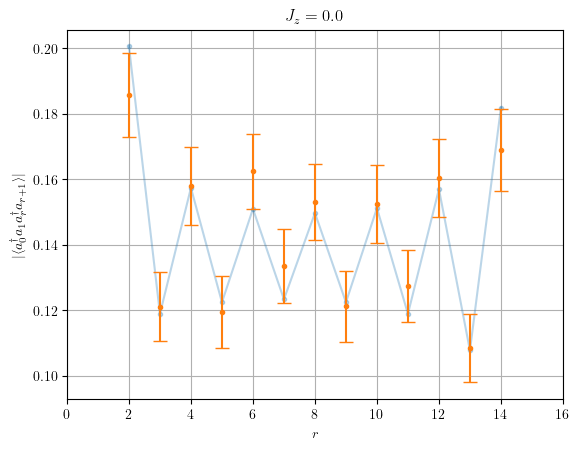

In [16]:
for (l,j,truth_data, recon_data, recon_data_std, _) in pmpmplot_data:
    pyplot.plot(range(1+1,l-1), abs(truth_data), '.-', alpha=0.3)
    pyplot.errorbar(range(1+1,l-1), abs(recon_data), yerr=recon_data_std, fmt='.', capsize=5)
    pyplot.title(r'$J_z={:.1f}$'.format(j))
    pyplot.ylabel(r'$|\langle a^{\dagger}_0 a_1 a^{\dagger}_r a_{r+1} \rangle|$')
    pyplot.xlabel('$r$')
    pyplot.grid()
    pyplot.xlim([0,16])
    pyplot.savefig('pmpmj{:.3f}.pdf'.format(j))
    pyplot.show()

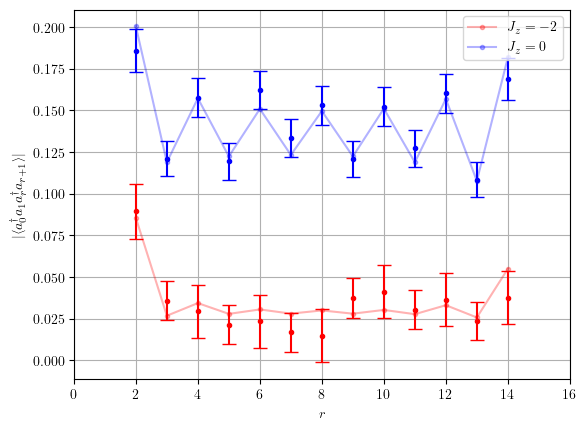

In [17]:
for (l,j,truth_data, recon_data, recon_data_std, _) in pmpmplot_data:
    near_zero = abs(j - 0.0) < 1e-6
    near_two = abs(j - (-2.0)) < 1e-6
    if near_zero or near_two:
        if near_zero:
            c = 'blue'
        else:
            c = 'red'
        pyplot.plot(range(1+1,l-1), abs(truth_data), '.-', alpha=0.3, c=c, label=r'$J_z={:.0f}$'.format(j))
        pyplot.errorbar(range(1+1,l-1), abs(recon_data), yerr=recon_data_std, c=c, fmt='.', capsize=5)

pyplot.ylabel(r'$|\langle a^{\dagger}_0 a_1 a^{\dagger}_r a_{r+1} \rangle|$')
pyplot.xlabel('$r$')
pyplot.grid()
pyplot.xlim([0,16])
pyplot.legend(loc='upper right')
pyplot.savefig('pmpmj_comp.pdf'.format(j))
pyplot.show()

# PPMM

In [18]:
if not os.path.exists('ppmmplot_data.pickle'):
    ppmmplot_data = []
    for (l, j, super_samples, gs) in data.values():
        samples = super_samples # Subset if desired
        recon_data = []
        recon_data_std = []
        truth_data = []
        raw_data = []

        recon = shadow_reconstruction.Reconstruction()
        for r in range(1+1,l-1):
            corr_check = make_pmpm(0,r,1,r+1).get_sparse(l)
            ground_truth = gs @ (corr_check @ gs)
            truth_data.append(ground_truth)

            string = ['I'] * l
            string[0] = '+'
            string[1] = '+'
            string[r] = '-'
            string[r+1] = '-'
            string = ''.join(string)
            estimates = recon.estimate_string_for_each_sample(string, samples)
            raw_data.append(estimates)
            recon_data.append(estimates.mean())
            recon_data_std.append(estimates.std()/numpy.sqrt(len(estimates)))
        recon_data = numpy.array(recon_data)
        recon_data_std = numpy.array(recon_data_std)
        truth_data = numpy.array(truth_data)
        ppmmplot_data.append((l,j,truth_data, recon_data, recon_data_std, raw_data))
    with open('ppmmplot_data.pickle', 'wb') as w:
        pickle.dump(ppmmplot_data, w)
else:
    with open('ppmmplot_data.pickle', 'rb') as f:
        ppmmplot_data = pickle.load(f)

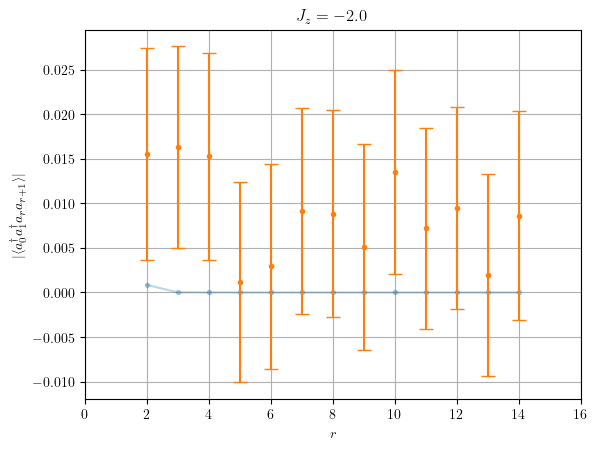

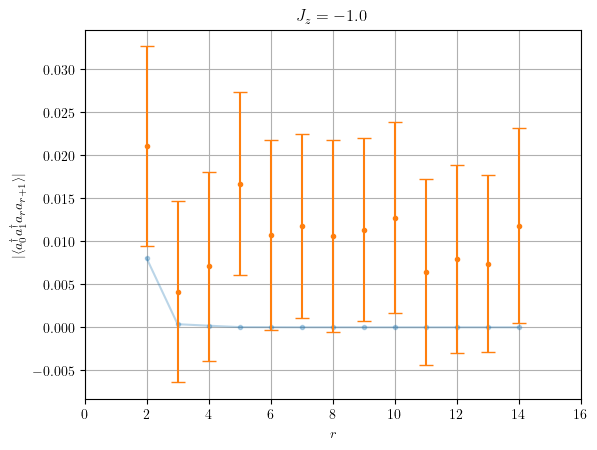

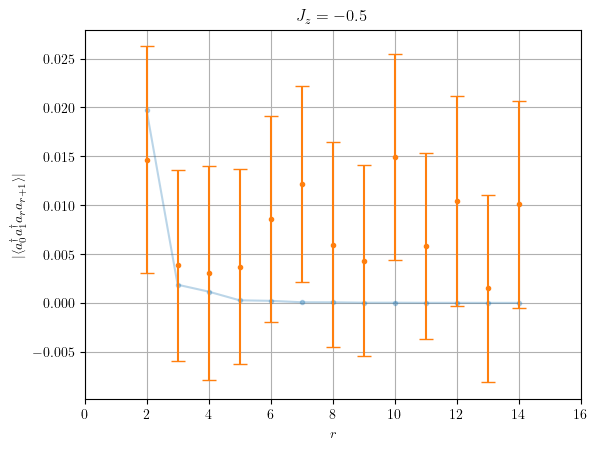

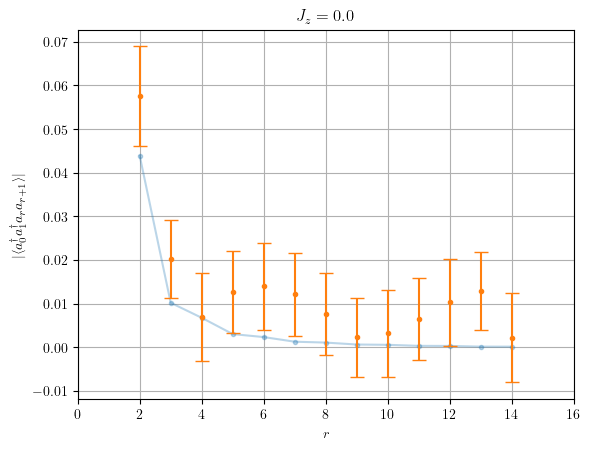

In [19]:
for (l,j,truth_data, recon_data, recon_data_std, _) in ppmmplot_data:
    pyplot.plot(range(1+1,l-1), abs(truth_data), '.-', alpha=0.3)
    pyplot.errorbar(range(1+1,l-1), abs(recon_data), yerr=recon_data_std, fmt='.', capsize=5)
    pyplot.title(r'$J_z={:.1f}$'.format(j))
    pyplot.ylabel(r'$|\langle a^{\dagger}_0 a^{\dagger}_1 a_r a_{r+1} \rangle|$')
    pyplot.xlabel('$r$')
    pyplot.grid()
    pyplot.xlim([0,16])
    pyplot.savefig('ppmmj{:.3f}.pdf'.format(j))
    pyplot.show()

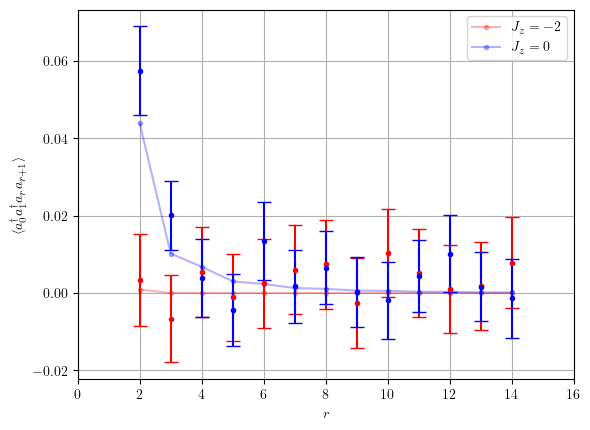

In [20]:
for (l,j,truth_data, recon_data, recon_data_std, _) in ppmmplot_data:
    near_zero = abs(j - 0.0) < 1e-6
    near_two = abs(j - (-2.0)) < 1e-6
    if near_zero or near_two:
        if near_zero:
            c = 'blue'
        else:
            c = 'red'
        pyplot.plot(range(1+1,l-1), (truth_data).real, '.-', alpha=0.3, c=c, label=r'$J_z={:.0f}$'.format(j))
        pyplot.errorbar(range(1+1,l-1), (recon_data).real, yerr=recon_data_std, c=c, fmt='.', capsize=5)

pyplot.ylabel(r'$\langle a^{\dagger}_0 a^{\dagger}_1 a_r a_{r+1} \rangle$')
pyplot.xlabel('$r$')
pyplot.grid()
pyplot.xlim([0,16])
pyplot.legend(loc='upper right')
pyplot.savefig('ppmmj_comp.pdf'.format(j))
pyplot.show()

# Median of Means

In [21]:
def median_of_means(array_data, chunk=None):
    if chunk is None:
        chunk = int(numpy.sqrt(len(array_data)))
    arrs = numpy.array_split(array_data, chunk)
    means = numpy.array([arr.mean() for arr in arrs])
    return numpy.median(means), 1.253 * numpy.std(means)/numpy.sqrt(len(means))

def mofm_convert(raw_data, chunk=None):
    means = []
    stds = []
    for array_data in raw_data:
        mu, sig = median_of_means(array_data, chunk=chunk)
        means.append(mu)
        stds.append(sig)
    return numpy.array(means), numpy.array(stds)

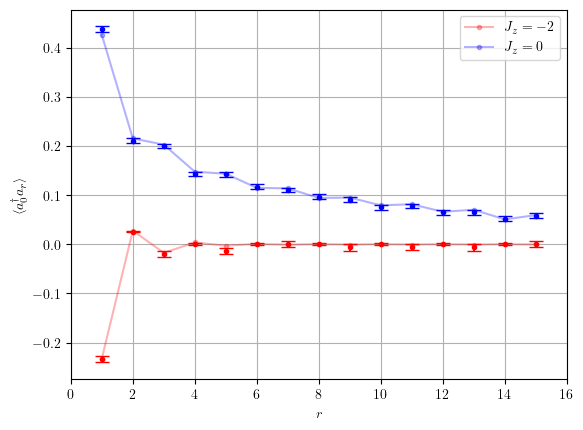

In [25]:
for (l,j,truth_data, _, _, raw_data) in plot_data:
    near_zero = abs(j - 0.0) < 1e-6
    near_two = abs(j - (-2.0)) < 1e-6
    if near_zero or near_two:
        if near_zero:
            c = 'blue'
        else:
            c = 'red'
        recon_data, recon_data_std = mofm_convert(raw_data)
            
        pyplot.plot(range(1,l), (truth_data).real, '.-', alpha=0.3, c=c, label=r'$J_z={:.0f}$'.format(j))
        pyplot.errorbar(range(1,l), (recon_data).real, yerr=recon_data_std, c=c, fmt='.', capsize=5)

pyplot.ylabel(r'$\langle a^{\dagger}_0 a_r \rangle$')
pyplot.xlabel('$r$')
pyplot.grid()
pyplot.xlim([0,16])
pyplot.legend(loc='upper right')
pyplot.savefig('median_of_means_pmj_comp.pdf')
pyplot.show()

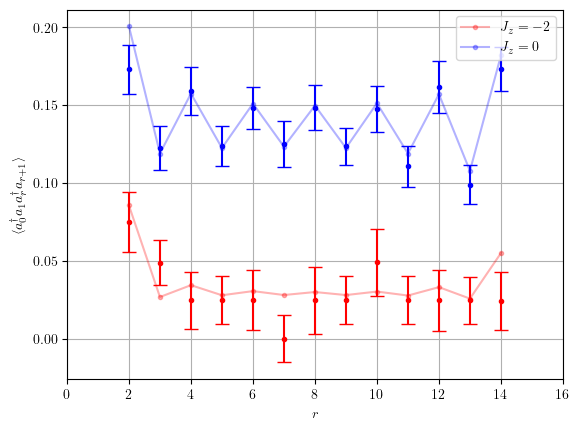

In [26]:
for (l,j,truth_data, _, _, raw_data) in pmpmplot_data:
    near_zero = abs(j - 0.0) < 1e-6
    near_two = abs(j - (-2.0)) < 1e-6
    if near_zero or near_two:
        if near_zero:
            c = 'blue'
        else:
            c = 'red'
        recon_data, recon_data_std = mofm_convert(raw_data)
            
        pyplot.plot(range(1+1,l-1), (truth_data).real, '.-', alpha=0.3, c=c, label=r'$J_z={:.0f}$'.format(j))
        pyplot.errorbar(range(1+1,l-1), (recon_data).real, yerr=recon_data_std, c=c, fmt='.', capsize=5)

pyplot.ylabel(r'$\langle a^{\dagger}_0 a_1 a^{\dagger}_r a_{r+1} \rangle$')
pyplot.xlabel('$r$')
pyplot.grid()
pyplot.xlim([0,16])
pyplot.legend(loc='upper right')
pyplot.savefig('median_of_means_pmpmj_comp.pdf')
pyplot.show()

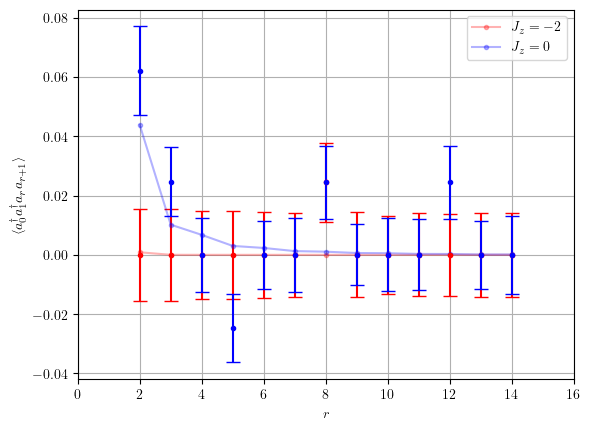

In [27]:
for (l,j,truth_data, _, _, raw_data) in ppmmplot_data:
    near_zero = abs(j - 0.0) < 1e-6
    near_two = abs(j - (-2.0)) < 1e-6
    if near_zero or near_two:
        if near_zero:
            c = 'blue'
        else:
            c = 'red'
        recon_data, recon_data_std = mofm_convert(raw_data)
            
        pyplot.plot(range(1+1,l-1), (truth_data).real, '.-', alpha=0.3, c=c, label=r'$J_z={:.0f}$'.format(j))
        pyplot.errorbar(range(1+1,l-1), (recon_data).real, yerr=recon_data_std, c=c, fmt='.', capsize=5)

pyplot.ylabel(r'$\langle a^{\dagger}_0 a^{\dagger}_1 a_r a_{r+1} \rangle$')
pyplot.xlabel('$r$')
pyplot.grid()
pyplot.xlim([0,16])
pyplot.legend(loc='upper right')
pyplot.savefig('median_of_means_ppmmj_comp.pdf')
pyplot.show()